# Twitter Customer Complains Analysis

## 1 Introduction

The goal of this project is to analyse tweets for the official pages of 50 companies from 7 different areas (retail, travel, finance, delivery, insurance, telecommunications and technology) and verify how did the amount of tweets change over three years.

### 1.1 Data Description

The data analysed here was scraped from Twitter using ```snscrape``` package. The data was taken from 15 random days in each of the months April-June for 2018, 2019 and 2020. The scraping took around 4 hours. The data obtained contains about 543 000 tweets.

The list of companies has both the official pages of the companies for general matters and customer support (e.g. @sainsburys, @AmericanAir, @Tesco, etc.), as well as pages for customer support only (e.g. @AmazonHelp, @FedExHelp, @AskLloydsBank, etc.). Part of the list was taken from the list of the 50 most responsive companies on Twitter here: https://hbr.org/2015/04/the-best-and-worst-corporate-tweeters

Disclaimer: For simplicity, in this notebook we will use the names of the companies' Twitter pages instead of the real names of the companies.

### 1.2 Main questions we want to answer:

1. Is there any effect of the pandemic on the frequency of Tweets with mentions of the companies' official Twitter accounts?
2. What are the differences in tweets regularity/sentiment between industries and/or companies?
3. For those companies for which the amount of tweets increased in 2020, was it due to more customer complains during the pandemic?
4. Can we identify which industries were more affected during the pandemic according to the data we obtained?


### 1.3 Sources


### 1.4 Install Commands for Packages used in this notebook

#### for sentiment analysis

#### for graphics

In [92]:
import pandas as pd
import numpy as np
import math
import datetime
import re

#import snscrape.modules.twitter as sntwitter

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_orig()

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


from ipywidgets import interact

## 2 Data 
### 2.1 Twitter Search using snscrape

The non-premium Twitter developer account has restrictions on tweets which can be downloaded per month and restrictions on time into the past one can search. Therefore, another solution is to use the ```snscrape``` package which may be found here: https://github.com/JustAnotherArchivist/snscrape

The package allows to scrape tweets into the past by either using a terminal or sending queries directly from python notebook. Although the tweets obtained from such scraping do not contain full data as opposed to Twyton functions, the user doesn't have to get a Twitter Developer account for scraping via snscrape, as guest credentials are used for scraping. 
More details on how the necessary data was obtained may be found in the separate file: ---.ipnb

Using the package ```pickle``` we transfer the results obtained in ---.ipnb into the objects within current notebook.

In [2]:
import pickle #package that allows to enter data saved from previos runs

# function for obtaining a list of tweets information lists
def tweets_info(file_number): 
    daytweets = pickle.load(open(f'daytweets_100_{file_number}.p',"rb"))
    daytweets_flat = [element for a_list in daytweets for element in a_list]
    tweetslist = [[tweet_tuple[0], #company name
                   tweet_tuple[1].date, tweet_tuple[1].id, #tweet information
                   tweet_tuple[1].content, tweet_tuple[1].lang,
                   tweet_tuple[1].user.username, tweet_tuple[1].user.location] 
                  for tweet_tuple in daytweets_flat]
    
    return tweetslist

In [3]:
# list of all tweets information lists 
tweetslists = [element for i in range(10) for element in tweets_info(i+1)] 

# dataframe with all the tweets and information we need
tweetsdf = pd.DataFrame(tweetslists,columns=['Company', 'Datetime', 'Tweet Id','Content',
                                             'Language', 'Username', 'UserAcc Location'])

## 3 Exploratory Data Analysis
### 3.1 Frequency of Tweets per Minute

As it was mentioned in the file ....ipynb our scraping queries were limited to 100 tweets per day. Therefore, to obtain information about tweets intensity we introduce a new metric. Namely, we want to explore the frequency of tweets per minute at each day we were scraping.

We calculate it using the following simple formula:
$$\frac{tw_d}{m_d},$$
where $tw_d$ is the amount of tweets obtained for a company at a single day and $m_d$ is the amount of minutes we were scraping this day (i.e. before the moment when algorithm stopped after obtaining 100 tweets for this day).

Of course, this metric is not ideal and just shows the frequencies of tweets only for several hours after 00:00 UTC, but it is enough for our goals. Moreover, we compare approximately the same daytime intervals in each year, what makes our analysis consistent.


Using the following two functions, we obtain a new dataframe with frequencies ordered by day and company.


In [37]:
def frequencies_list(df): # column name to compute the metrics for it
    newdf = df.copy() # create a copy for precaution: so that we don't change the original df
    metrics_list = []
    for company in newdf['Company'].unique():
        company_mask = (newdf['Company']==company)
        df_datetime = pd.to_datetime(newdf['Datetime'][company_mask]).apply(lambda x: x.date())
        #print(sorted(df_datetime.unique()))
        for day in df_datetime.unique():
            day_mask = (df_datetime == day)
            
            # sort values of the datetime stamps for this day just in case
            datetime_sorted = sorted(newdf['Datetime'][company_mask][day_mask].values)
            
            #print(datetime_sorted)
            # how many minutes we were scraping this day
            day_len_min = (datetime_sorted[-1]-datetime_sorted[0]).astype('timedelta64[m]').astype(int)
            
            if day_len_min != 0:
                # divide the amount of mitues we were scraping this day by the amount of tweets we got
                # and append it with the day and company to the metrics_list
                metrics_list.append([company,day,len(datetime_sorted)/day_len_min])
#             else:
#                 day_tweets = np.sum(day_mask & company_mask)
#                 if day_tweets != 0:
#                     tweets_for_metrics = np.sum(day_mask & company_mask & mask_for_metrics)
#                     metrics_list.append([company,day,tweets_for_metrics/day_tweets])
    return metrics_list
                    

def list_to_df(list_of_lists, list_of_columns):
    df = pd.DataFrame(list_of_lists, columns = list_of_columns)
    df['Year'] = df['Date'].apply(lambda x: x.year)
    df = df.set_index('Date')
    return df
 

In [38]:
frequencies = frequencies_list(tweetsdf)
freqdf = list_to_df(frequencies, ['Company', 'Date', 'Frequency'])

# testdf = tweetsdf[-1500:-1].copy(0)
# frequencies_list(testdf)
# #testdf

In [75]:
freqdf#[freqdf['Frequency'] == freqdf['Frequency'].max()]
    
# sentiment_df.loc[sentiment_df[sentiment_df.Company==company].index, 
#                           'Industry'] = companies.Area[companies.Company==company].values[0]


#     freqdf = pd.DataFrame(columns = ['Frequency', 'Company', 'Year'])
# freqdf = freqdf[freqdf['Frequency']!=0]
# for company in tweetsdf['Company'].unique():
#     freqdf = freqdf.append(dict_to_df(company,tweets_dict))

,Company,Frequency,Year
Date,,,
2018-04-17,DirectLine,0.014245,2018
2018-04-21,DirectLine,0.034375,2018
2018-04-06,DirectLine,0.023161,2018
2018-04-19,DirectLine,0.018018,2018
2018-04-28,DirectLine,0.013793,2018
...,...,...,...
2020-06-10,bookingcom,0.159744,2020
2020-06-27,bookingcom,0.121655,2020
2020-06-19,bookingcom,0.180832,2020


In [123]:
def barplots(df, column, title):
    df2018 = df[df.Year==2018]
    df2018 = df2018.groupby(['Company'])[column].agg('mean')
    df2018 = df2018.rename("2018")

    df2019 = df[df.Year==2019]
    df2019 = df2019.groupby(['Company'])[column].agg('mean')
    df2019 = df2019.rename("2019")

    df2020 = df[df.Year==2020]
    df2020 = df2020.groupby(['Company'])[column].agg('mean')
    df2020 = df2020.rename("2020")

    new_df = pd.concat([df2018, df2019, df2020], axis=1).sort_values(by='2018', ascending=False)

    fig, ax = plt.subplots(figsize = (15,6))
    new_df.plot.bar(edgecolor='none', alpha = 0.5,figsize = (16,5), ax=ax)
    #ax.set_xticklabels(frequencies.index,rotation = 30)
    ax.set_title(title)
    plt.show()

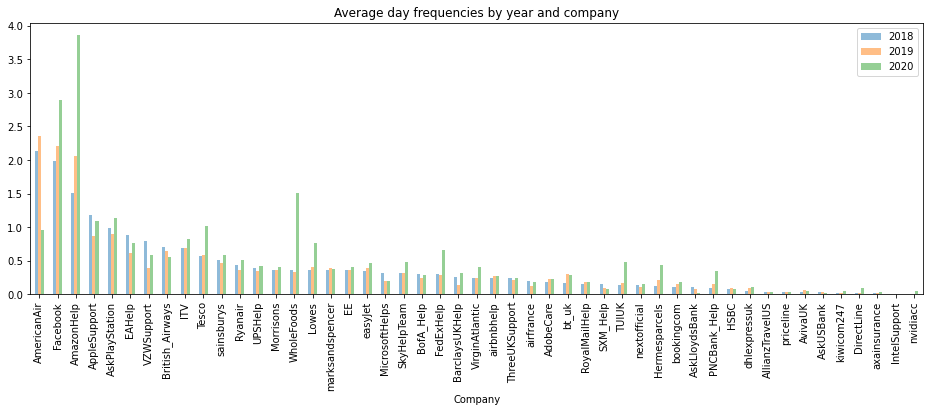

In [124]:
barplots(freqdf, 'Frequency', 'Average day frequencies by year and company')

As we can see from the bar plot above, for some companies (e.g. WholeFoods, FedExHelp, TUIUK, etc.) the yearly average of the day tweets frequencies for 2020 increased more than two times in comparison to 2018 and 2019. Whilst, there are other companies, like AmericanAir or AskLloyds, where there is a significant decrease in average daily tweets frequencies, or no change at all (marksandspencer, BofA_Help, etc.)

In [ ]:
# def freq_violinplot(company):
#     freq_company = freq_clipped[freq_clipped['Company']==company]
#     data_boxplot = [freq_company['Frequency'][freq_company['Year']==2018],
#                 freq_company['Frequency'][freq_company['Year']==2019],
#                 freq_company['Frequency'][freq_company['Year']==2020]]

#     fig, ax = plt.subplots(figsize=(10, 4))
    
#     pos = [0, 1, 2]

#     plt.violinplot(data_boxplot,
#              pos, #widths=0.3,#points=100,
#              showmeans=True,
#             showextrema=True, 
#              showmedians=True)

#     ax.set_ylabel('tweets frequency per day')
#     ax.set_xlabel(company)
#     #ax.set(ylim=(0, ))
#     ax.set_xticks([0, 1, 2])
#     ax.set_xticklabels(['2018', '2019', '2020'], fontsize='small');#points=100,
#     #plt.show()

In [ ]:
# interact(freq_violinplot, company=tweetsdf['Company'].unique())

### 3.2 Logarithhmic frequences distributions

In [116]:
# 
mask_freq = (freqdf['Frequency']>0.001) 

freq_clipped_log = freqdf[mask_freq]
freq_clipped_log['Frequency'] = np.log(freq_clipped_log['Frequency'])
#freq_clipped['Frequency'].plot(figsize = (20,8), color = 'green')
#freq_clipped['Frequency']

def freq_violinplot_log(company):
    freq_company_log = freq_clipped_log[freq_clipped_log['Company']==company]
    data_boxplot = [freq_company_log['Frequency'][freq_company_log['Year']==2018],
                freq_company_log['Frequency'][freq_company_log['Year']==2019],
                freq_company_log['Frequency'][freq_company_log['Year']==2020]]

    fig, ax = plt.subplots(figsize=(10, 4))
    
    pos = [0, 1, 2]

    plt.violinplot(data_boxplot,
             pos, #widths=0.3,#points=100,
             showmeans=True,
            showextrema=True, 
             showmedians=True)

    ax.set_ylabel('log(tweets frequency per day)')
    ax.set_xlabel(company)
    #ax.set(ylim=(0, ))
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['2018', '2019', '2020'], fontsize='small');#points=100,
    #plt.show()

In [117]:
interact(freq_violinplot_log, company=tweetsdf['Company'].unique())

interactive(children=(Dropdown(description='company', options=('DirectLine', 'sainsburys', 'nextofficial', 'Am…

<function __main__.freq_violinplot_log(company)>

## 4 Text Sentiment Analysis
### 4.1 Models for sentiment
We analyse the content of each tweet using two packages based on similar algorithms: TextBlob and VADER. Both of them do not need to pretrain a model in order to apply it and are relatively easy and quick to apply.

In [76]:
# function to clean up the text for the analysis
def cleanUpTweet(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    # text = re.sub(r'#', '', text)
    # Remove retweets:
    text = re.sub(r'RT : ', '', text)
    # Remove urls
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
    return text



#### 4.1.1 TextBlob
We will use just one property of the TextBlob `sentiment` package `sentimemt.polarity`. For a given text it returns a number from the interval $[-1,1]$. We define a function for the TextBlob sentiment score, which is "negative"(i.e. $=-1$) for negative values of `sentiment.polarity`, "neutral" (i.e. $=0$) for the value zero, and "positive" $(=1)$ for positive values of polarity.


In [62]:
def Polarity(txt):
    return TextBlob(txt).sentiment.polarity

def TextBlobScore(a):
    if a < 0:
        return -1
    elif a == 0:
        return 0
    else:
        return 1

In [78]:
# Clean the dataframe before the sentiment analysis

# Drop Tweets from companies themselves
clean_tweetsdf = tweetsdf.copy()
for company in clean_tweetsdf['Company'].unique():
    clean_tweetsdf = clean_tweetsdf.drop(clean_tweetsdf[clean_tweetsdf['Username']==company].index)

# Clean the Content column leaving just text
clean_tweetsdf['Content'] = clean_tweetsdf['Content'].apply(cleanUpTweet)

# Drop Empty sentences
clean_tweetsdf = clean_tweetsdf.drop(clean_tweetsdf[clean_tweetsdf['Content']==' '].index)
clean_tweetsdf = clean_tweetsdf.drop(clean_tweetsdf[clean_tweetsdf['Content']==''].index)

# Drop non English Tweets
clean_tweetsdf = clean_tweetsdf.drop(clean_tweetsdf[clean_tweetsdf['Language']!='en'].index)



In [79]:
# Apply Subjectivity Function
# clean_tweetsdf['Subjectivity_TextBlob'] = clean_tweetsdf['Content'].apply(Subjectivity)

# Apply Polairity to obtain new column
clean_tweetsdf['PolarityTextBlob'] = clean_tweetsdf['Content'].apply(Polarity)

# Apply Polarity Score to obtain new column
clean_tweetsdf['Score_TextBlob'] = clean_tweetsdf['PolarityTextBlob'].apply(TextBlobScore)

#### 4.1.2 VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner) is more oriented to texts on social networks. Valence is a score representing emotional alignment of a word. We will use `SentimentIntensityAnalyzer.polarity_score()` function, which returns a dictionary of text sentiment information.

We are interested in the metric `compound` which, according to the documentation, represents a "*normalised weighted composite score computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalised to be between -1 (most extreme negative) and 1 (most extreme positive)*".

Due to its definition, in our `VADERscore` function we will slightly adjust the score for VADER metric in comparison to the one for TextBlob by assigning a "neutral" ($=0$) score to any compound score from the interval $(-0.05, 0.05)$, and "positive" to any value greater or equal to $0.05$, and "negative" to any value smaller or equal to $-0.05$.

In [82]:
clean_tweetsdf['CompoundVADER'] = clean_tweetsdf['Content'].apply(lambda x: analyser.polarity_scores(x)['compound'])

In [83]:
# Tranfers the compound parameter into score
def VADERscore(compound_score):
    if compound_score >= 0.05:
        score = 1
    elif (compound_score > -0.05)&(compound_score < 0.05):
        score = 0
    else:
        score = -1
    return score

In [84]:
# obtain a column of scores
clean_tweetsdf['Score_VADER'] = clean_tweetsdf['CompoundVADER'].apply(VADERscore)

### 4.3 Negative Sentiment Rates

In [86]:
sentim_df = clean_tweetsdf.copy() 
sentim_df['Datetime'] = pd.to_datetime(sentim_df['Datetime']).apply(lambda x: x.date())
#days = pd.to_datetime(sentiment_df['Datetime']).apply(lambda x: x.date()).unique()
sentim_list = []

for company in sentim_df['Company'].unique():
    company_mask = (sentim_df['Company']==company)
    sentiment_mask_tb = (sentim_df['Score_TextBlob'] == -1)
    sentiment_mask_vad = (sentim_df['Score_VADER'] == -1)
    
    for day in sentim_df['Datetime'].unique():
        day_mask = (sentim_df['Datetime'] == day)
        day_tweets = np.sum(day_mask & company_mask)
        if day_tweets != 0:
            # TextBlob
            day_sentim_tweets_tb = np.sum(day_mask & company_mask & sentiment_mask_tb)
            
            # VADER
            day_sentim_tweets_vad = np.sum(day_mask & company_mask & sentiment_mask_vad)
            
            # append the list with a list of new information
            sentim_list.append([company,day,day_sentim_tweets_tb/day_tweets,day_sentim_tweets_vad/day_tweets])

            
#[[company,day,np.sum((sentim_df['Datetime'] == day)&(sentim_df['Company']==company) & (sentim_df['Score_TextBlob'] == -1))/day_tweets,day_sentim_tweets_vad/day_tweets]]
            
            
            
# def metrics_list(df, metrics_amount): # column name to compute the metrics for it
#     newdf = df.copy()
#     newdf['Datetime'] = pd.to_datetime(newdf['Datetime']).apply(lambda x: x.date())
#     metrics_list = []
    
#     if metrics_amount == 2
#         metrics_mask_tb = (newdf['Score_TextBlob'] == -1)
#         metrics_mask_vad = (newdf['Score_VADER'] == -1)

#     # will be used in the later analysis
#     if metrics_amount = 3
#         metrics_mask_covid = newdf['COVID']
    
#     for company in newdf['Company'].unique():
#         company_mask = (newdf['Company']==company)

#         for day in newdf['Datetime'].unique():
#             day_mask = (newdf['Datetime'] == day)
#             day_tweets = np.sum(day_mask & company_mask)
#             if day_tweets != 0:
#                 tweets_for_metrics = np.sum(day_mask & company_mask & mask_for_metrics)
#                 metrics_list.append([company,day,tweets_for_metrics/day_tweets])
#     return metrics_list

In [87]:
sentiment_df = list_to_df(sentim_list, ['Company', 'Date', 'NegativeRateTextBlob', 'NegativeRateVADER'])

In [88]:
sentiment_df.head()

,Company,NegativeRateTextBlob,NegativeRateVADER,Year
Date,,,,
2018-04-22,DirectLine,0.0,1.0,2018
2018-04-02,DirectLine,0.0,0.0,2018
2018-05-11,DirectLine,1.0,0.0,2018
2018-05-22,DirectLine,0.0,1.0,2018
2018-05-09,DirectLine,0.2,0.2,2018


#### 4.2.1 Barplot for Negative Sentiment Rate

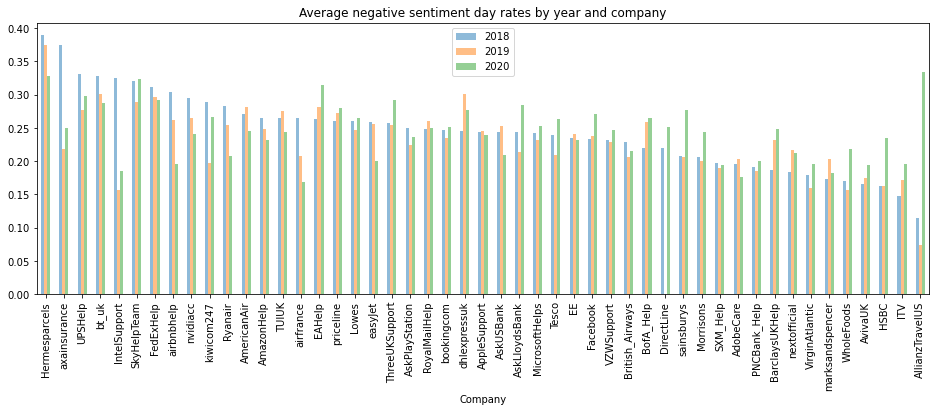

In [138]:
barplots(sentiment_df, 'NegativeRateTextBlob', 'Average negative sentiment day rates by year and company')

#### 4.2.2 Confidence Intervals for Logarithmic Negative Sentiment Rates

In [126]:
mask_sentim = (sentiment_df['NegativeRateTextBlob']>=0.0001) & (sentiment_df['NegativeRateVADER']>=0.0001) 
sentiment_log = sentiment_df.copy()[mask_sentim]
sentiment_log['log-NegativeRateTextBlob'] = np.log(sentiment_log['NegativeRateTextBlob'])
sentiment_log['log-NegativeRateVADER'] = np.log(sentiment_log['NegativeRateVADER'])
#sentim_log['NegativeRateVADER'] = np.log(sentim_log['NegativeRateVADER'])
#

def sentim_boxplot_log(company, rate):
    sentim_company = sentiment_log[sentiment_log['Company']==company]
    data_plot = [sentim_company[rate][sentim_company['Year']==2018],
                sentim_company[rate][sentim_company['Year']==2019],
                sentim_company[rate][sentim_company['Year']==2020]]

    fig, ax = plt.subplots(figsize=(10, 4))
    
    pos = [0, 1, 2]

    sns.boxplot(data = data_plot)#,
#              pos, #widths=0.3,#points=100,
#              showmeans=True,
#             showextrema=True, 
#              showmedians=True)

    ax.set_ylabel('log(Negative Sentiment)')
    ax.set_xlabel(company)
    #ax.set(ylim=(0, ))
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['2018', '2019', '2020'], fontsize='small');#points=100,
    plt.show()

In [127]:
interact(sentim_boxplot_log,
         company=tweetsdf['Company'].unique(),
         rate = [('TextBlob Rate','log-NegativeRateTextBlob'),('VADER Rate', 'log-NegativeRateVADER')])

interactive(children=(Dropdown(description='company', options=('DirectLine', 'sainsburys', 'nextofficial', 'Am…

<function __main__.sentim_boxplot_log(company, rate)>

### 4.3 Wordclouds

In [105]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Update the default stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["u", "now", "one", "will", "Hi", "day", "think", "don", "t", 
                  "know", "amp", "s", "today", "got", "say", "Thank", "Thanks", 
                  "see", "go", "please", "thing", "people", "us", "ve", "m"])


In [113]:
# Adding a column with year to the dataframe
#clean_tweetsdf.loc[clean_tweetsdf.index, 'Year'] = pd.to_datetime(clean_tweetsdf['Datetime']).apply(lambda x: x.year)
clean_tweetsdf['Year'] = pd.to_datetime(clean_tweetsdf['Datetime']).apply(lambda x: x.year)

def wordcloud(year,company):
    # Create the text for the given year
    year_mask = (clean_tweetsdf.Year==year)
    company_mask = (clean_tweetsdf.Company==company)
    text = " ".join(tweet for tweet in clean_tweetsdf.Content[year_mask & company_mask])

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

    # Display the generated image:
    plt.figure(figsize=[16,10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [114]:
interact(wordcloud,
         year = [2018, 2019, 2020],
         company = tweetsdf['Company'].unique())

interactive(children=(Dropdown(description='year', options=(2018, 2019, 2020), value=2018), Dropdown(descripti…

<function __main__.wordcloud(year, company)>

### 4.4 COVID Sentiment analysis

In [129]:
search_words = ["covid", "pandemic", "covid19", "lockdown", "corona", 
                "virus", "coronavirus", "covid-19", "covd19", "mask"]
def contains_covid(text):
    text_listed = re.split('[; |, |\*|\n#().?""''+$&!/%^§=´`*_:<>]', text.lower())
    return any(word in text_listed for word in search_words)

In [131]:
clean_tweetsdf.loc[:,'COVID'] = clean_tweetsdf['Content'].apply(lambda x: contains_covid(x))

In [132]:
covid_sentiment_df = clean_tweetsdf.copy() 
covid_sentiment_df['Datetime'] = pd.to_datetime(covid_sentiment_df['Datetime']).apply(lambda x: x.date())
#days = pd.to_datetime(sentiment_df['Datetime']).apply(lambda x: x.date()).unique()

covid_sentim_list = []
#covid_sentiment = {}

for company in covid_sentiment_df['Company'].unique():
    company_mask = (covid_sentiment_df['Company']==company)
    covid_sentiment_mask = covid_sentiment_df['COVID']
    
    for day in covid_sentiment_df['Datetime'].unique():
        #print(day)
        day_mask = (covid_sentiment_df['Datetime'] == day)
        #print(np.sum(day_mask))
        day_tweets = np.sum(day_mask & company_mask)
        #print(day_tweets)
        if day_tweets != 0:
            # TextBlob
            day_sentim_tweets = np.sum(day_mask & company_mask & covid_sentiment_mask)
            #covid_sentiment[day] = day_sentim_tweets/day_tweets
            covid_sentim_list.append([company,day,day_sentim_tweets/day_tweets])

In [134]:
covid_sentim_df = list_to_df(covid_sentim_list, ['Company', 'Date', 'COVID_sentiment'])

In [135]:
covid_sentim_df

,Company,COVID_sentiment,Year
Date,,,
2018-04-22,DirectLine,0.000000,2018
2018-04-02,DirectLine,0.000000,2018
2018-05-11,DirectLine,0.000000,2018
2018-05-22,DirectLine,0.000000,2018
2018-05-09,DirectLine,0.000000,2018
...,...,...,...
2019-06-27,bookingcom,0.000000,2019
2018-06-14,bookingcom,0.000000,2018
2019-05-07,bookingcom,0.000000,2019


In [139]:
# Dataframe with new column 'Industry'

companies = pd.read_csv("CompaniesList.csv", header = None)
companies.columns = ['Company', 'Industry']

for company in covid_sentim_df['Company'].unique():
    company_mask = (covid_sentim_df.Company==company)
    covid_sentim_df.loc[covid_sentim_df[company_mask].index, 'Industry']\
        = companies.Industry[companies.Company==company].values[0]



Text(0.5, 1.0, 'COVID Word Frequencies in April-June 2020 by company')

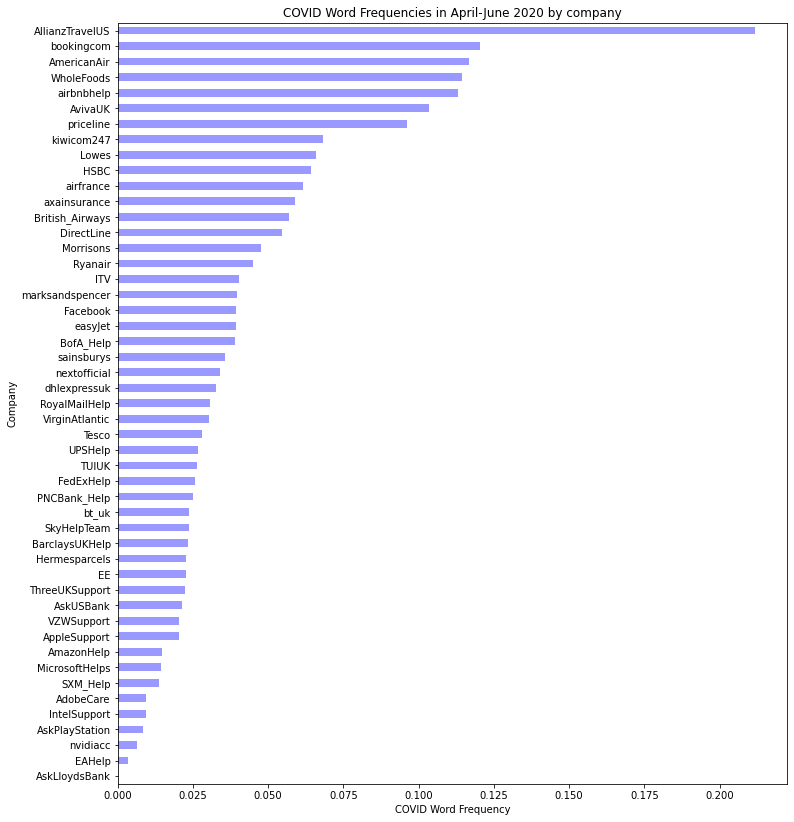

In [140]:
covid_score_df = covid_sentim_df[covid_sentim_df.index>pd.to_datetime('2019-12-31')].groupby(['Company'])['COVID_sentiment'].agg('mean')

#event_df = df.groupby('type')['type'].agg('count')

fig, ax = plt.subplots(figsize=(12, 14))

#org_df.sort_values(ascending=False).head(20).plot(kind='bar', color='b', alpha=0.4, ax=axes[0])
#org_df.sort_values(ascending=True).tail(20).plot(kind='bar', color='b', alpha=0.4, ax=axes[0])
covid_score_df.sort_values().plot(kind='barh', color='b', alpha=0.4)
ax.set_xlabel('COVID Word Frequency')
ax.set_title( 'COVID Word Frequencies in April-June 2020 by company')
#event_df.sort_values().plot(kind='barh', color='b', alpha=0.4, ax=axes[1])

#axes[1].set_xlabel('Number of events')

#fig.subplots_adjust(wspace=0.8);

## 5 Correlations Between Metrics

In this section we want to sum up the observasions from the two previous sections and verify whether there is any correlation between the metrics we built.

In [ ]:
clean_tweetsdf['Date'] =  pd.to_datetime(clean_tweetsdf['Datetime']).apply(lambda x: x.date())

In [158]:

def metrics_list(df): # column name to compute the metrics for it
    #new_df = df.copy() # create a copy for precaution: so that we don't change the original df
    metrics_list = []
    sentiment_mask_tb = (df['Score_TextBlob'] == -1)
    sentiment_mask_vad = (df['Score_VADER'] == -1)
    covid_sentiment_mask = df['COVID']
    for day in new_df['Date'].unique():
        day_mask = (df['Date'] == day)
        for company in df[day_mask]['Company'].unique():
            company_mask = (df['Company']==company)
            day_mask_short = (df[company_mask]['Date'] == day)
            
            day_company_mask = (day_mask & company_mask)
            # for frequency
            day_tweets = np.count_nonzero(day_company_mask)
            if day_tweets != 0:
                # TextBlob
                day_sentim_tweets_tb = np.count_nonzero(day_company_mask & sentiment_mask_tb)
            
                # VADER
                day_sentim_tweets_vad = np.count_nonzero(day_company_mask & sentiment_mask_vad)
                    
                # COVID
                covid_tweets = np.count_nonzero(day_company_mask & covid_sentiment_mask)
                
                # for frequency
                datetime_sorted = sorted(df['Datetime'][company_mask][day_mask_short].values)
                day_len_min = (datetime_sorted[-1]-datetime_sorted[0]).astype('timedelta64[m]').astype(int)
                
                if day_len_min != 0:
                    #freq_metric = len(datetime_sorted)/day_len_min
                    # append the list with a list of new information
                    metrics_list.append([company,day,
                                        len(datetime_sorted)/day_len_min, # frequency
                                        day_sentim_tweets_tb/day_tweets, # TextBlob metric
                                        day_sentim_tweets_vad/day_tweets, # VADER metric
                                        covid_tweets/day_tweets #COVID metric
                                       ])
              
    return metrics_list


In [163]:
metrics_lists = metrics_list(clean_tweetsdf)
#clean_tweetsdf

In [164]:
metrics_df = list_to_df(metrics_lists, ['Company', 'Date', 'frequency_met', 'TextBlob_met', 'VADER_met', 'COVID_met'])

In [184]:
#sorted(metrics_df.index)[-100:-1]
metrics_df.head()

,Company,frequency_met,TextBlob_met,VADER_met,COVID_met,Year
Date,,,,,,
2018-04-22,nextofficial,0.080866,0.239437,0.183099,0.000000,2018
2018-04-22,AmericanAir,1.080000,0.203704,0.314815,0.000000,2018
2018-04-22,Tesco,0.310484,0.246753,0.272727,0.000000,2018
2018-04-22,AllianzTravelUS,0.003742,0.000000,0.000000,0.000000,2018
2018-04-22,British_Airways,0.376543,0.245902,0.377049,0.016393,2018


In [181]:
metric_df_2018_2019 = metrics_df[(metrics_df['Year']==2018) | (metrics_df['Year']==2019)]

In [189]:
meanfreq_2018_2019 = metric_df_2018_2019.groupby(['Company'])['frequency_met'].agg('mean')
meanTBrate_2018_2019 = metric_df_2018_2019.groupby(['Company'])['TextBlob_met'].agg('mean')
meanVADrate_2018_2019 = metric_df_2018_2019.groupby(['Company'])['VADER_met'].agg('mean')

In [202]:
df_2018_2019 = pd.concat([meanfreq_2018_2019, meanTBrate_2018_2019, meanVADrate_2018_2019, 
                          pd.Series(1, index = meanVADrate_2018_2019.index)], axis = 1)

In [191]:
metrics_2020 = metrics_df[(metrics_df['Year']==2020)]

In [196]:
meanfreq_2020 = metrics_2020.groupby(['Company'])['frequency_met'].agg('mean')
meanTBrate_2020 = metrics_2020.groupby(['Company'])['TextBlob_met'].agg('mean')
meanVADrate_2020 = metrics_2020.groupby(['Company'])['VADER_met'].agg('mean')
COVIDrate_2020 = metrics_2020.groupby(['Company'])['COVID_met'].agg('mean')

In [208]:
df_2020 = pd.concat([meanfreq_2020, meanTBrate_2020, meanVADrate_2020, COVIDrate_2020], axis = 1)
df_2020 = df_2020/df_2018_2019.values
 

,frequency_met,TextBlob_met,VADER_met,COVID_met
Company,,,,
AdobeCare,1.181163,0.882650,1.025505,0.009540
AllianzTravelUS,1.498304,4.108017,4.734799,0.225720
AmazonHelp,1.953355,0.904122,0.927338,0.014745
AmericanAir,0.439522,0.888206,0.843242,0.116780
AppleSupport,1.093068,0.976968,0.903640,0.020387
AskLloydsBank,0.182214,0.521168,0.000000,0.000000
AskPlayStation,1.368722,0.994937,1.030675,0.008488
AskUSBank,0.728250,0.926772,0.889905,0.022990
AvivaUK,0.837691,1.135470,1.167616,0.103405


In [237]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='frequency_met',
                                 values=df_2020['frequency_met']),
                            dict(label='TextBlob_met',
                                 values=df_2020['TextBlob_met']),
                            dict(label='VADER_met',
                                 values=df_2020['VADER_met']),
                            dict(label='COVID_met',
                                 values=df_2020['COVID_met'])],
                text=df_2020.index.values,
                marker=dict(#color=df_2020.index.values,
                            #showscale=False, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))


fig.update_layout(
    title='Correlation of Twitter Metrics',
    dragmode='select',
    width=900,
    height=900,
    hovermode='closest',
)

fig.show()

## 6 Conclusion

We obtained the following answers to the questions we stated at the beginning.

1. Is there any effect of the pandemic on the frequency of Tweets with mentions of the companies' official Twitter accounts?
First of all, there are some companies (Amazon, Whole Foods, Tesco, FedEx, TUI UK, Hermes, Lowes, DirectLine) where we can see a significant increase of the frequencies of Tweets in April-June 2020 in comparison to the same periods in 2018 and 2019. For other companies (American Air, Lloyds Bank, British Airways) there is a visible decrease in Tweets frequencies per day for the same period in comparison to the previous years.

Further, analysis of the word clouds for these companies showed us that indeed the lexicon changed towards the one used during the pandemic. In particular, for TUI UK we saw that in 2018 and 209 the most popular words were 'holidays' and 'flight', whereas now it is 'refund' and 'cancelled'. Similar picture we see for insurance companies which also provide travel insurance. For retal companies, like Whole Foods or Tesco, the sentiment analysis showed a significant increase in popularity of the words 'queue' and 'line'. The most popular word for Whole Foods in Tweets from Arpil-June 2020 was the word 'mask'. 
2. What are the differences in tweets regularity/sentiment between industries and/or companies?
The companies with increase in Tweets frequencies are mostly from retail, delivery, travel and insurance. If we take a look at the word clouds for 
Some other companies 
For companies like 
3. For those companies for which the amount of tweets increased in 2020, was it due to more customer complains during the pandemic?

4. Can we identify which industries were more affected during the pandemic according to the data we obtained?
According to tha data we analysed, there is a definite effect of the pandemic on areas like retail, delivery, travel, even financial services. But it is different for different companies. And if for retail we see a definite increase in both frequency and sentiment or deliery we 



